# Overview: Training a Home Assistant Robot with Reinforcement Learning

Imagine a robot assistant for your home who can help with chores like cleaning up, loading the dishwasher, or putting away the groceries. 
Reinforcement learning (RL) can be used for robots to autonomously learn to complete these types of tasks. 
The recently released [Habitat 2.0 simulator](https://arxiv.org/abs/2106.14405) is a simulator for virtual agents to learn to complete tasks in the home. 
The video below shows the simulator in action where using reinforcement learning a robot was trained to set the table. 

In [ ]:
from IPython.display import HTML
HTML('<iframe src="https://drive.google.com/file/d/1ltrse38i8pnJPGAXlThylcdy8PMjUMKh/preview" width="640" height="480" allow="autoplay"></iframe>')

But in this assignment, we will focus on a simpler problem.
Instead, of doing tasks around the whole house, we will focus on training the robot to move the gripper to a desired 3D position. Below shows a picture of that. 

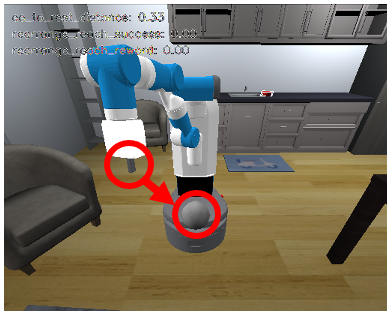

The robot's gripper is highlighted in red.
The robot must move its arm such that the gripper reaches the red circle. 
To do so, the robot can control the angle of each of its 7 joints shown below. 


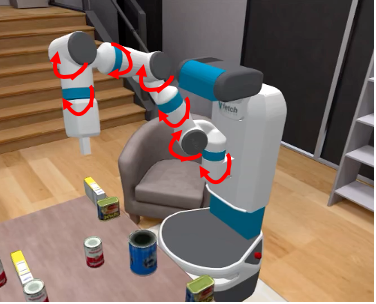

We will train an agent with reinforcement learning to control the joint angles to move the gripper to the desired location. 
To make things easier the robot arm always starts in the same position and the goal for the gripper is always the same. 
Some more details about our Markov Decision Process: 

* The observation space is the current angles in radians of all 7 joints and the 3D position of the goal. 
* The action space is the desired difference in joint angles in radians for all 7 joints. The [Bullet Physics](https://pybullet.org/wordpress/) simulator then controls the motors to try to achieve the desired joint state. 
* Each episode is 20 steps long. 

Since we are working with a continuous action space, our agent will need to output continuous 7D vectors for actions. 
We will explore how different reinforcement learning algorithms can solve this problem. 

# Setup

In [ ]:
# Install the Habitat Simulator and download the necessary data. This takes about 6 minutes to complete, but it only needs to be run once!
# This cell will only run on Colab. To install locally, follow the installation steps in the README.
import os
if "COLAB_GPU" in os.environ:
    !curl -L https://github.com/facebookresearch/habitat-sim/blob/main/examples/colab_utils/colab_install.sh | NIGHTLY=true bash -s

In [ ]:
########################################################################
# Imports. Nothing to do here. 
########################################################################
%env MAGNUM_LOG=quiet
%env HABITAT_SIM_LOG=quiet

import os
import os.path as osp
from collections import deque

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from habitat_sim.utils import viz_utils as vut
from IPython.display import Image, display
from torch.distributions import Normal
from tqdm import tqdm

env_settings = ['SIMULATOR.CONCUR_RENDER', False, 'TASK.EE_SAMPLE_FACTOR', 0.0]

In [ ]:
########################################################################
# Some helper utilities. Also, nothing to do here.
########################################################################

class ToTensorWrapper(gym.Wrapper):
    def step(self, action):
        action_np = action.cpu().numpy()[0]
        obs, reward, done, info = super().step(action_np)
        return self._modify_obs(obs), reward, done, info

    def reset(self):
        obs = super().reset()
        return self._modify_obs(obs)

    def render(self, **kwargs):
        return self.env.render(**kwargs)

    def _modify_obs(self, obs):
        # modify obs
        return torch.tensor(obs).view(1, -1)


def fix_random_seed():
    torch.manual_seed(42)
    np.random.seed(42)


def make_plot(
    plot_success,
    plot_name,
    name,
    eval_val=None,
):
    X = np.arange(len(plot_success))
    if not osp.exists("data"):
        os.makedirs("data")
    plt.plot(X, plot_success)
    plt.xlabel("Update Iteration")
    plt.ylabel(plot_name)
    if eval_val is None:
        plt.title(f"{plot_name} Plot")
    else:
        plt.title(f"{plot_name} Plot: Eval {eval_val:.4f}")
    plot_name = f"data/{name}_{plot_name.lower().replace(' ', '_')}.png"
    plt.savefig(plot_name)
    plt.clf()

    if vut.is_notebook():
        display(Image(plot_name))


def visualize_policy(env, policy, video_name, evaluate_stochastic=False):
    with torch.no_grad():
        video_file = f"data/{video_name}.mp4"
        fps = 30
        with vut.get_fast_video_writer(video_file, fps=fps) as writer:
            obs = env.reset()
            done = False
            while not done:
                obs, reward, done, info = env.step(
                    policy.get_action(obs, evaluate=not evaluate_stochastic)
                )
                writer.append_data(env.render(mode="rgb_array"))

        # Evaluate the policy for 10 episodes
        all_reward = []
        all_success = []
        for _ in range(10):
            obs = env.reset()
            done = False
            episode_reward = 0.0
            success = False
            while not done:
                obs, reward, done, info = env.step(
                    policy.get_action(obs, evaluate=True)
                )
                episode_reward += reward
            all_reward.append(episode_reward)
            all_success.append(info["rearrange_reach_success"])
        print(
            "Evaluation reward %.4f, Reached Goal %.4f"
            % (np.mean(all_reward), np.mean(all_success)),
        )
        if vut.is_notebook():
            vut.display_video(video_file)
    return np.mean(all_reward), np.mean(all_success)


def verify_policy(policy):
    obs = torch.randn(1, 10)
    dist = policy(obs)
    assert isinstance(dist, Normal)
    assert dist.mean.shape == (1, 7)

    ac = policy.get_action(obs, evaluate=False)
    assert ac.shape == (1, 7)
    print("Policy  returns the correct shape")


def verify_value_func(value_func):
    obs = torch.randn(20, 10)
    value = value_func(obs)
    assert value.shape == (20, 1)
    print("Value function returns the correct shape")


def verify_return_calculation(compute_returns):
    test_rewards = torch.arange(20).view(20)
    returns = compute_returns(test_rewards, 0.99)

    assert torch.allclose(
        returns,
        torch.tensor(
            [
                166.9075,
                168.5934,
                169.2863,
                168.9760,
                167.6525,
                165.3056,
                161.9249,
                157.4998,
                152.0201,
                145.4748,
                137.8533,
                129.1448,
                119.3381,
                108.4224,
                96.3862,
                83.2184,
                68.9075,
                53.4419,
                36.8100,
                19.0000,
            ]
        ),
    )
    print("Returns calculation seems correct!")

Let's start by seeing what a random policy does in this environment. 
This policy just randomly chooses joint targets in the range -1 to 1.
Unsurprisingly, it can never reach the goal! 

In [ ]:
###################################################################################
# Run to see the random policy in action. Nothing to do here. 
# This step might download the datasets if they have not already been downloaded.
###################################################################################
import habitat.utils.gym_definitions
class RandomPolicy:
    def __init__(self, env):
        super().__init__()
        self._action_space = env.action_space

    def get_action(self, obs, evaluate):
        return self._action_space.sample()

env = gym.make("HabitatRenderReachState-v0", override_options=env_settings)
policy = RandomPolicy(env)

visualize_policy(env, policy, "random")
env.close()

# REINFORCE

In lecture we learned about the REINFORCE algorithm, a reinforcement learning algorithm that uses policy gradients. 
We will use REINFORCE here to solve the robot reaching problem because it can easily work with continuous action spaces, like the continuous action space to control the robot joints. 
First recall that the REINFORCE algorithm **maximizes** the following objective 
$$
\mathcal{L}(\theta) = \mathbb{E}_{(s,a) \sim \pi} \left[
  \sum_{t=1}^T \log \pi_\theta (a_t | s_t) G_t
\right]
$$
For a batch size of $N$ trajectories, a maximum episode horizon of $T$, and **episode return** (not reward!) $R_i$. 
The return is the sum of discounted rewards from time $t$ until the end of the episode.
For discounting factor $\gamma$ this is 
$$
G_t = \sum_{k = t}^T \gamma^{k - t} r_k
$$
To work with the continuous action space, we will represent the policy $\pi(a_t | s_t) $ as a [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution). 
The policy architecture, visualized below, is a deep neural network that takes as input the current state and outputs the mean of the Normal distribution. 
The standard deviation is a separately learned parameter. 
The standard deviation controls how random the agent acts, or how much it explores. 
For this problem, we don't need this exploration to depend on the state and can instead have the agent automatically adjust the randomness between episodes. 

For stability, also use the **log of the standard deviation** rather than the standard deviation. You can also initialize the log standard deviation parameter with zeros. 

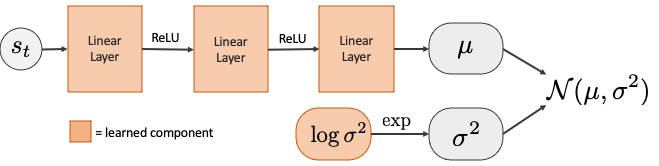

Start by implementing the policy architecture in the above figure. 

In [ ]:
class NeuralNetworkPolicy(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super().__init__()
        ########################################################################
        # TODO: Create the neural network that will output the parameters of
        # the action normal distribution. Since we are in a continuous action
        # space the policy should output a Normal distribution. See
        # https://pytorch.org/docs/stable/generated/torch.normal.html for more
        # details.
        # IMPORTANT IMPLEMENTATION DETAILS:
        # - The standard deviation should be a SINGLE LEARNABLE PARAMETER. It
        # should NOT be output by a neural network.
        # - Learn the log(standard_deviation) rather than the
        # standard_deviation.
        # - The mean should be the output of a neural network with one hidden
        # layer, ReLU activations, and a hidden dimension size of 64
        ########################################################################


        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, obs):
        ########################################################################
        # TODO: Get the normal distribution. This function should return a type
        # torch.distributions.Normal
        ########################################################################
        
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def get_action(self, obs, evaluate):
        ########################################################################
        # TODO: If evaluate=True, return the most likely action (the mean of
        # the normal distribution). If evaluate=False, sample a random action
        # from the Normal distribution.
        ########################################################################
        
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [ ]:
# Create the RL environment.
env = gym.make("HabitatRenderReachState-v0", override_options=env_settings)
# The regular environment outputs numpy arrays of shape (obs_dim,) and takes as
# input actions as numpy arrays of shape (ac_dim,). This is not compatible with
# our neural network policy which uses PyTorch tensors and requires a batch
# dimension. The `ToTensorWrapper` therefore converts the environment to return
# observations tensors of shape (1, obs_dim) and action tensors of shape (1,
# action_dim).
env = ToTensorWrapper(env)

########################################################################
# The fixed hyperparameters for the algorithm. Do NOT change these!
########################################################################
# The number of updates to the policy
n_updates = 120
# The fixed number of steps in the episode
episode_length = 20
# The discounting factor
gamma = 0.99
# The policy learning rate
lr = 1e-3
# The observation space dimensions from the environment. In our case this is
# always (7 of joints) + (3D displacement to the goal) = 7 + 3 = 10
obs_dim = env.observation_space.shape[0]
# The action space from the environment. In our case this is always the number
# of joints since we are sending commands to each joint as an action.
# Therefore, this is always 7.
action_dim = env.action_space.shape[0]

In [ ]:
########################################################################
# TODO: Setup the policy and the policy optimizer.
# Use Adam with a learning rate of 1e-3
########################################################################
policy = None
########################################################################
#                             END OF YOUR CODE                         #
########################################################################

# Make sure the shapes of the policy is correct.
# NOTE: Even if this runs without an assertion error. This does not mean your
# policy is working correctly. The shapes could be correct, but the output
# incorrect.
verify_policy(policy)

In [ ]:
def compute_returns(all_rewards, gamma):
    """
    :param all_rewards: torch tensor of shape (episode_length,)
    :param gamma: float for the discounting factor
    :returns: torch tensor of shape (episode_length,)
    """
    all_returns = torch.zeros(episode_length)
    ########################################################################
    # TODO: Compute the returns to update the policy. This function is called
    # before the policy optimization step you have to implement.
    ########################################################################
    
    ########################################################################
    #                             END OF YOUR CODE                         #
    ########################################################################
    return all_returns

verify_return_calculation(compute_returns)

Now fill out the training loop and implement the REINFORCE algorithm to train the policy. 
We are not only recording the reward, but also the success rate of if the robot is able to reach the goal within the episode. 

In [ ]:
# Some logging information
plot_rewards = []
plot_success = []
running_episode_reward = deque([], 10)
running_episode_success = deque([], 10)
fix_random_seed()

for update_i in tqdm(range(n_updates)):
    episode_reward = 0.0
    episode_success = 0
    all_obs = torch.zeros(episode_length + 1, obs_dim)
    all_actions = torch.zeros(episode_length, action_dim)
    all_rewards = torch.zeros(episode_length)

    obs = env.reset()
    all_obs[0] = obs[0]

    ########################################################################
    # TODO: Collect data from 1 episode! Be sure to collect
    # - episode_reward: This is the sum of all rewards in the episode
    # - episode_success: This is `info["any_reach_success"]` from the final
    #   step
    # - all_obs: The observations from the environment. There is 1 more than
    #   the episode length because the agent starts in a state and THEN takes 20
    #   steps.
    # - all_actions: The actions the agent took
    # - all_rewards: The per time step rewards
    # During policy inference NO gradients should be stored. See
    # https://pytorch.org/docs/stable/generated/torch.no_grad.html for how to
    # achieve this.
    ########################################################################
    
    ########################################################################
    #                             END OF YOUR CODE                         #
    ########################################################################

    all_returns = torch.zeros(episode_length)
    ########################################################################
    # TODO: Compute the returns to update the policy
    ########################################################################
    
    ########################################################################
    #                             END OF YOUR CODE                         #
    ########################################################################


    ########################################################################
    # TODO: Update the policy
    ########################################################################
    
    ########################################################################
    #                             END OF YOUR CODE                         #
    ########################################################################

    # Logging code
    running_episode_success.append(episode_success)
    running_episode_reward.append(episode_reward)

    plot_success.append(np.mean(running_episode_success))
    plot_rewards.append(np.mean(running_episode_reward))
    print(f"Update {update_i}, Reward: {plot_rewards[-1]}, Success: {plot_success[-1]}")

## Deliverable 1 (10 points)
Run the following code to plot the reward and success rate across the agent updates. 
This will also evaluate the policy and render the output to a video.
This is what your agent learned to do!

For full credit you should achieve greater than 5.0 **evaluation reward (not training reward)**.

In [ ]:
reward, succ = visualize_policy(env, policy, "reinforce")
make_plot(plot_success, "Success", "reinforce", succ)
make_plot(plot_rewards, "Reward", "reinforce", reward)

# Actor-Critic

## Base Algorithm
Next, we will implement a more advanced RL algorithm we saw from the lectures: the advantage Actor Critic algorithm. 
This works similarly to REINFORCE, but uses the value function as a baseline. 
Theoretically this reduces variance, and practically we will see this results in a higher performing RL algorithm. 
We can write the Actor Critic loss as 
$$
\mathcal{L}_P(\theta) = -\mathbb{E}_{(s,a) \sim \pi} \left[
  \sum_{t=1}^T \log \pi_\theta (a_t | s_t) A_t
\right]
$$
Where the advantage $A_t$ is computed as 
$$
A_t = G_t - V_\phi(s_t)
$$
Where $G_t$ is the same return from REINFORCE and $V_\phi(s_t)$ is a *learned value estimator*. 
Now we have to train two neural networks, our policy $\pi_\theta$ to minimize $\mathcal{L}(\theta)$ and $V_\phi$ to predict the value from a particular state. 
We can train the value function to predict the value from a particular state by minimizing the loss
$$
\mathcal{L}_V(\phi) = \mathbb{E}_{s_t \sim \pi_\theta} \left[ \left( G_t - V(s_t) \right)^2
\right]
$$

## Entropy Loss
In addition to the standard Actor-Critic loss, we will also use an additional _entropy loss_. 
This loss will encourage the policy distribution to have higher entropy, therefore, encouraging exploration. 
You can easily calculate the entropy of the [Normal distribution in PyTorch.](https://pytorch.org/docs/stable/generated/torch.normal.html) 
The entropy loss is defined as 
$$
\mathcal{L}_E(\theta) =
\mathbb{E}_{(s,a) \sim \pi_\theta}  
\left[
-H [ \pi_\theta (a | s) ]
\right]
$$
Why negative? We are *minimizing* this loss, but want a _higher_ entropy. 
When computing the entropy of a vector (our multi-dimensional action output) be sure to take the summation over the entropy of each dimension rather than the average.
Our total loss for the actor-critic algorithm is then
$$
\mathcal{L} = \mathcal{L}_P + \lambda_V \mathcal{L}_V + \lambda_E \mathcal{L}_E
$$
Where $\lambda_V, \lambda_E$ are the learning rates of the value and entropy loss. 

In [ ]:
########################################################################
# Same setup as the previous part, with slightly different hyperparameters. For
# more details, see the previous part. Like last part, do NOT change these!
########################################################################

n_updates = 200
episode_length = 20
gamma = 0.99
lr = 1e-3
value_coef = 0.1
entropy_coef = 0.0001
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

In [ ]:
########################################################################
# TODO: Initialize the policy and the value function. Use the same policy as
# before. The value function should have one hidden layer with a hidden
# dimension of 64 and ReLU activations.
#
# You can use a single optimizer for both the policy and value function
# or you can do it with two optimizers. Regardless the learning rate for the
# value function should be 0.1 the learning rate of the policy.
########################################################################



########################################################################
#                             END OF YOUR CODE                         #
########################################################################

In [ ]:
# For logging.
plot_rewards = []
plot_success = []
plot_value_loss = []
plot_entropy_loss = []
running_episode_reward = deque([], 10)
running_episode_success = deque([], 10)
fix_random_seed()

for update_i in tqdm(range(n_updates)):
    episode_reward = 0.0
    episode_success = 0
    all_obs = torch.zeros(episode_length + 1, obs_dim)
    all_actions = torch.zeros(episode_length, action_dim)
    all_rewards = torch.zeros(episode_length)

    obs = env.reset()
    all_obs[0] = obs[0]

    all_returns = torch.zeros(episode_length)

    ########################################################################
    # TODO: Use your same data collection and return calculation code from the last part.
    ########################################################################
    
    ########################################################################
    #                             END OF YOUR CODE                         #
    ########################################################################

    ########################################################################
    # TODO: Update the policy AND value function using the Actor-Critic
    # learning rule.
    #
    # Also add the entropy loss to the policy update. Weight the entropy loss
    # by 0.0001.
    #
    # Be sure to set the `value_loss` and `entropy_loss` as
    # torch.tensor float variables! After this code block we call
    # `entropy_loss.item()`  and `value_loss.item()` to log them.
    ########################################################################
    
    ########################################################################
    #                             END OF YOUR CODE                         #
    ########################################################################

    # Logging code
    running_episode_success.append(episode_success)
    running_episode_reward.append(episode_reward)

    plot_success.append(np.mean(running_episode_success))
    plot_rewards.append(np.mean(running_episode_reward))
    plot_value_loss.append(value_loss.item())
    plot_entropy_loss.append(entropy_loss.item())

    print(f"Update {update_i}, Reward: {plot_rewards[-1]}, Success: {plot_success[-1]}")

## Deliverable 2 (10 points total)
### Evaluation Performance (6 points)
For full credit you should achieve greater than 6.0 **evaluation reward (not training reward!)**.

### Entropy Loss (2 points)
2 points for correctly computing the entropy loss as reflected by the entropy loss plot. 

### Value Loss (2 points)
2 points for correctly computing the value loss as reflected by the value loss plot. 



In [ ]:
reward, succ = visualize_policy(env, policy, "a2c")
make_plot(plot_success, "Success", "a2c", succ)
make_plot(plot_rewards, "Reward", "a2c", reward)
make_plot(plot_entropy_loss, "Entropy Loss", "a2c")
make_plot(plot_value_loss, "Value Loss", "a2c")

# Harder Task (Extra Credit)
But what if the goal for the gripper changed every episode? 
Then the agent would have to adapt its behavior to achieve the different goal. 

Using the components you implemented in the previous sections, try to train an agent with RL to solve this task. 

You may want to investigate: 
- Learning rate decay: decreasing the learning rate over time. 
- Gradient clipping: See [the PyTorch documentation for more information.](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)
- Advantage normalization: Make sure the advantage tensor has 0 mean and 1 standard deviation.

In [ ]:
# We need to shut down the previous environment before creating a new one. 
env.close()

env = gym.make("HabitatRenderReachState-v0", override_options=['SIMULATOR.CONCUR_RENDER', False])
env = ToTensorWrapper(env)
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]


########################################################################
# These are hyperparameters you should NOT change.
########################################################################
n_updates = 160 # Don't change number of updates.
episode_length = 20
gamma = 0.99

In [ ]:
# For logging.
plot_rewards = []
plot_success = []
plot_value_loss = []
plot_entropy_loss = []
running_episode_reward = deque([], 10)
running_episode_success = deque([], 10)
fix_random_seed()

# PUT YOUR SETUP CODE HERE

for update_i in tqdm(range(n_updates)):
    episode_reward = 0.0
    episode_success = 0
    all_obs = torch.zeros(episode_length + 1, obs_dim)
    all_actions = torch.zeros(episode_length, action_dim)
    all_rewards = torch.zeros(episode_length)

    obs = env.reset()
    all_obs[0] = obs[0]

    # PUT YOUR TRAINING CODE HERE

    # Logging code
    running_episode_success.append(episode_success)
    running_episode_reward.append(episode_reward)

    plot_success.append(np.mean(running_episode_success))
    plot_rewards.append(np.mean(running_episode_reward))
    plot_value_loss.append(value_loss.item())
    plot_entropy_loss.append(entropy_loss.item())

    print(f"Update {update_i}, Reward: {plot_rewards[-1]}, Success: {plot_success[-1]}")

########################################################################
#                             END OF YOUR CODE                         #
########################################################################

## Deliverable 3 (6 points extra credit)
To achieve full credit for this section, your agent must achieve greater than 0.0 evaluation reward. 

In [ ]:
reward, succ = visualize_policy(env, policy, "full")
make_plot(plot_success, "Success", "full", succ)
make_plot(plot_rewards, "Reward", "full", reward)
make_plot(plot_entropy_loss, "Entropy Loss", "full")
make_plot(plot_value_loss, "Value Loss", "full")